# Patient Model: Diagnosis Classification

In [ ]:
%cd ..

In [3]:
import random
from os.path import join

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from helpers import get_confidence_interval
from src.utils.config import pipeline_config
from src.utils.constants import SEED

# Set random seeds and deterministic pytorch for reproducibility
random.seed(SEED)       # python random seed
np.random.seed(SEED) # numpy random seed

%matplotlib inline

In [4]:
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

from statsmodels.stats.proportion import proportion_confint

In [5]:
classes = ["Control", "Bact. Pneumonia", "Viral Pneumonia", "Obst. Bronchitis", "Asthma", "Bronchiolitis"]
n_classes = len(classes)
patient_df = pd.read_csv("../data/patient_df.csv")
train_loc = pipeline_config["train_loc"]

In [6]:
patient_df

,patient,location,fold,diagnosis,old_diagnosis,all_diagnoses,multilabel
0,Pn_GVA_Co1,GVA,4,0,0,[0],False
1,Pn_GVA_Co2,GVA,0,0,0,[0],False
2,Pn_GVA_Co3,GVA,1,0,0,[0],False
3,Pn_GVA_Co4,GVA,2,0,0,[0],False
4,Pn_GVA_Co5,GVA,3,0,0,[0],False
...,...,...,...,...,...,...,...
588,Pn_RBA_Ca27,RBA,4,4,-1,[4],False
589,Pn_RBA_Ca28,RBA,0,4,-1,[4],False
590,Pn_RBA_Ca33,RBA,1,4,-1,[4],False
591,Pn_RBA_Ca34,RBA,2,4,-1,[4],False


In [7]:
diagnosis_unknown = ['Pn_POA_Ca6', 'Pn_POA_Ca12', 'Pn_POA_Ca13', 'Pn_POA_Ca18', 'Pn_POA_Ca20', 
                     'Pn_POA_Ca23', 'Pn_POA_Ca24', 'Pn_POA_Ca26', 'Pn_POA_Ca32', 'Pn_POA_Ca37', 
                     'Pn_POA_Ca40', 'Pn_POA_Ca41', 'Pn_POA_Ca44', 'Pn_POA_Ca45', 'Pn_POA_Ca47', 
                     'Pn_POA_Ca48', 'Pn_POA_Ca49', 'Pn_POA_Ca56', 'Pn_POA_Ca60', 'Pn_POA_Ca67', 
                     'Pn_POA_Ca69', 'Pn_POA_Ca76', 'Pn_POA_Ca79', 'Pn_POA_Ca89', 'Pn_POA_Ca90', 
                     'Pn_POA_Ca92', 'Pn_POA_Ca93', 'Pn_POA_Ca99', 'Pn_POA_Ca103', 'Pn_POA_Ca104', 
                     'Pn_POA_Ca105', 'Pn_POA_Ca113', 'Pn_POA_Ca123', 'Pn_POA_Ca127', 'Pn_POA_Ca136', 
                     'Pn_POA_Ca140', 'Pn_POA_Ca142', 'Pn_POA_Ca144', 'Pn_POA_Ca148', 'Pn_POA_Ca152', 
                     'Pn_POA_Ca166', 'Pn_POA_Ca170', 'Pn_POA_Ca173', 'Pn_POA_Ca179', 'Pn_POA_Ca182', 
                     'Pn_POA_Ca186', 'Pn_POA_Ca188', 'Pn_POA_Ca189', 'Pn_POA_Ca190', 'Pn_POA_Ca191', 
                     'Pn_POA_Ca193', 'Pn_POA_Ca213', 'Pn_POA_Ca218', 'Pn_POA_Ca223', 'Pn_POA_Ca224', 
                     'Pn_POA_Ca225', 'Pn_POA_Ca227', 'Pn_POA_Ca228', 'Pn_POA_Ca232', 'Pn_POA_Ca234', 
                     'Pn_POA_Ca236', 'Pn_POA_Ca242', 'Pn_POA_Ca245']

In [8]:
def filter_patients(patient_preds, patient_meta, target):
    if target[0] != 0:
        print("Removing patients with multiple diagnoses")
        diagnosis_filter = ~patient_meta.multilabel
        patient_preds = patient_preds[diagnosis_filter]
        patient_meta = patient_meta[diagnosis_filter]

    if 3 in target or 5 in target:
        print("Removing patients with unknown diagnosis")
        diagnosis_filter = ~patient_preds.index.isin(diagnosis_unknown)
        patient_preds = patient_preds[diagnosis_filter]
        patient_meta = patient_meta[diagnosis_filter]
        
    return patient_preds, patient_meta

In [9]:
def experiment(model, max_duration, selected_positions, target):
    meta = []
    data = []
    for fold_1, fold_2 in pipeline_config["cv_folds"]:
        print('#'*25, f"FOLD {fold_1}-{fold_2}", '#'*25) 
        test_meta_1, X_test_1 = position_aggregation(model, max_duration, selected_positions, target, val_fold=fold_1, test_fold=fold_2)
        print()
        print('#'*25, f"FOLD {fold_2}-{fold_1}", '#'*25)
        test_meta_2, X_test_2 = position_aggregation(model, max_duration, selected_positions, target, val_fold=fold_2, test_fold=fold_1)
        meta += [test_meta_1, test_meta_2]
        data += [X_test_1, X_test_2]
        print()
        
    internal_meta, external_meta = post_process_predictions(meta)
    return internal_meta, external_meta

In [10]:
def position_aggregation(model, max_duration, selected_positions, target, val_fold, test_fold):
    position_df = patient_df.copy()
    labels = (position_df.diagnosis.isin(target)).values.astype(int)
    position_df["label"] = labels
    
    loc_selection = (position_df.location.isin(train_loc)).values
    val_indices = (position_df.fold == val_fold).values & loc_selection
    test_indices = (position_df.fold == test_fold).values | (~loc_selection)
    #test_indices = (~loc_selection)

    position_df = position_df.assign(set="train")
    position_df.loc[val_indices, "set"] = "val"
    position_df.loc[test_indices, "set"] = "test"
    
    # Get sample features
    target_str = '+'.join([str(t) for t in target])
    df_dir = join(pipeline_config["out_folder"], "aggregate", str(max_duration))
    output_df_file = join(df_dir,
                          pipeline_config["aggregate_file"].format(pipeline_config["network"]["feature_model"], target_str, val_fold, test_fold))
    output_df = pd.read_csv(output_df_file)
    position_df = position_df.merge(output_df, on="patient")
    
    patient_preds, patient_meta = mean_output_dataset(position_df, target_str)
    patient_preds, patient_meta = filter_patients(patient_preds, patient_meta, target)  # Added
    patient_preds = patient_preds[selected_positions]
    print(patient_preds.columns)
    test_meta, X_test = simple_fit(model, patient_preds, patient_meta)
    
    return test_meta, X_test

In [11]:
def mean_output_dataset(position_df, target_str):
    output_col = f"output_{target_str}"
    all_preds = position_df.pivot(index="patient", columns="position", values=output_col).dropna()
    patient_meta = position_df.drop(columns=["position", output_col]).drop_duplicates()
    patient_meta = patient_meta.set_index("patient").loc[all_preds.index.values]

    return all_preds, patient_meta

In [12]:
def simple_fit(model, patient_preds, patient_meta):
    test_selection = (patient_meta.set == "test").values
    test_data, test_meta = patient_preds[test_selection], patient_meta[test_selection]
    train_data, train_meta = patient_preds[~test_selection], patient_meta[~test_selection]
    
    X_test, y_test = test_data.values, test_meta.label.values
    X_train, y_train = train_data.values, train_meta.label.values
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    #clf = hyperparameter_tuning(X_train, y_train, train_meta)
    #y_pred = clf.predict(X_test)
    #test_meta = test_meta.assign(prediction=y_pred)
    probs = model.predict_proba(X_test)
    #probs = clf.predict_proba(X_test)
    test_meta = test_meta.assign(probability=probs[:, 1])    
    
    return test_meta, X_test

In [13]:
def post_process_predictions(meta):
    internal_meta = []
    external_meta = []
    
    for meta_df in meta:
        internal_df = meta_df[meta_df.location.isin(train_loc)].reset_index()
        internal_df = internal_df.assign(prediction=(internal_df.probability > 0.5).astype(int))
        internal_meta.append(internal_df)
        
        external_df = meta_df[~meta_df.location.isin(train_loc)].reset_index()
        external_meta.append(external_df)
    
    external_meta = pd.concat(external_meta)
    external_meta = external_meta.groupby(['patient', 'location', 'diagnosis', 'label'])[["probability"]].mean()
    external_meta = external_meta.assign(prediction=(external_meta.probability > 0.5).astype(int))
    external_meta = external_meta.reset_index()
    
    return internal_meta, external_meta

In [14]:
import scipy.stats


def performance_stats(output_df):
    y_true = output_df.label.values
    y_pred = output_df.prediction.values
    y_score = output_df.probability.values
    
    report = classification_report(y_true, y_pred, output_dict=True)
    sensitivity = report['1']['recall']
    specificity = report['0']['recall']
    auc = roc_auc_score(y_true, y_score)
    
    return sensitivity, specificity, auc

In [15]:
def internal_statistics(internal_meta):
    sensitivity_ls, specificity_ls, auc_ls = [], [], []
    for internal_df in internal_meta:
        sensitivity, specificity, auc = performance_stats(internal_df)
        sensitivity_ls.append(sensitivity)
        specificity_ls.append(specificity)
        auc_ls.append(auc)
    
    sens_mean, sens_std = np.mean(sensitivity_ls), np.std(sensitivity_ls)
    spec_mean, spec_std = np.mean(specificity_ls), np.std(specificity_ls)
    auc_mean, auc_std = np.mean(auc_ls), np.std(auc_ls)
    
    # Final Stats
    stats_dict = {
        "Internal": {
            "Sensitivity (SD)": "{:.3f} ({:.3f})".format(sens_mean, sens_std), 
            "Specificity (SD)": "{:.3f} ({:.3f})".format(spec_mean, spec_std), 
            "AUROC (SD)": "{:.3f} ({:.3f})".format(auc_mean, auc_std),
        }
    }
    stats_df = pd.DataFrame.from_dict(stats_dict, orient="index")
    
    return sens_mean, spec_mean, auc_mean

In [16]:
def external_statistics(external_meta, binomial_ci="beta", alpha=0.05):
    # Sensitivity
    positives = external_meta[external_meta.label == 1]
    n_pos = len(positives)
    true_pos = positives.prediction.sum()
    sensitivity = true_pos/n_pos
    sens_lower, sens_upper = proportion_confint(
        count=true_pos,
        nobs=n_pos,
        alpha=alpha,
        method=binomial_ci
    )
        
    # Specificity
    negatives = external_meta[external_meta.label == 0]
    n_neg = len(negatives)
    true_neg = n_neg - negatives.prediction.sum()
    specificity = round(true_neg/n_neg, 3)
    spec_lower, spec_upper = proportion_confint(
        count=true_neg,
        nobs=n_neg,
        alpha=alpha,
        method=binomial_ci
    )
    
    # AUC
    auc, auc_ci = get_confidence_interval(
        y_true=external_meta.label.values, 
        y_score=external_meta.probability.values
    )
    auc_lower, auc_upper = auc_ci[0], auc_ci[1]
    
    # Final Stats
    stats_dict = {
        "External": {
            "Sensitivity (CI95)": "{:.3f}  ({:.3f}-{:.3f})".format(sensitivity, sens_lower, sens_upper), 
            "Specificity (CI95)": "{:.3f}  ({:.3f}-{:.3f})".format(specificity, spec_lower, spec_upper), 
            "AUROC (CI95)": "{:.3f}  ({:.3f}-{:.3f})".format(auc, auc_lower, auc_upper),
        }
    }
    stats_df = pd.DataFrame.from_dict(stats_dict, orient="index")
    
    return sensitivity, specificity, auc

### Plotting Results

In [17]:
# Import seaborn
import seaborn as sns

# Apply the default theme
sns.set_theme()

In [18]:
sns.set_style("whitegrid")

In [19]:
fontsize = 22  # 18
titlesize = 24  # 24
plt.rc('font', size=fontsize)          # controls default text sizes
plt.rc('axes', titlesize=titlesize)     # fontsize of the axes title
plt.rc('axes', labelsize=fontsize)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('legend', fontsize=fontsize)    # legend fontsize
plt.rc('figure', titlesize=titlesize)  # fontsize of the figure title

In [20]:
from sklearn.metrics import auc, roc_curve, roc_auc_score


def duration_auc_scores(max_durations, position_subsets, target):
    auc_scores = [[] for _ in range(len(position_subsets))]
    
    for max_duration in max_durations:
        for i, selected_positions in enumerate(position_subsets):
            model = make_pipeline(LogisticRegression(random_state=0, class_weight="balanced", solver="liblinear"))
            internal_meta, external_meta = experiment(model, max_duration, selected_positions, target)
            _, _, external_auc = external_statistics(external_meta)
            auc_scores[i].append(external_auc)
    
    return auc_scores


#y_min=0.56
def plot_roc_curve(max_durations, position_subsets, labels, target, baseline=0., y_min=0.3, y_max=0.9, delta=0.005, show_legend=False):    
    target_str = '+'.join([str(t) for t in target])
    fig_file = "../images/duration-auc-{}.png".format(target_str)    
    fig, ax = plt.subplots(figsize=(15,10))
    auc_scores = duration_auc_scores(max_durations, position_subsets, target)
    print(auc_scores)
    
    # Plot ROC curve
    for i, subset_scores in enumerate(auc_scores):
        ax.plot(max_durations, subset_scores, label=labels[i], lw=3)
    
    # Plot baseline
    ax.plot([max_durations[0], max_durations[-1]], [baseline, baseline], linestyle='--', 
            lw=2, color='r', label='Baseline', alpha=1.0)
    
    ax.set_xlabel('Duration')
    ax.set_ylabel('AUROC')
    print(ax.get_ylim())
    ax.set_ylim((y_min-delta, y_max+delta))
    if show_legend:
        ax.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig(fig_file)
    plt.show()

In [21]:
max_durations = np.linspace(start=2.5, stop=30, num=12)
print(max_durations)

[ 2.5  5.   7.5 10.  12.5 15.  17.5 20.  22.5 25.  27.5 30. ]


In [22]:
position_subsets = [
    ['P1'],
    ['P1', 'P2'],
    ['P1', 'P2', 'P5', 'P6'],
    ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8']
]

labels = [str(len(subset)) for subset in position_subsets]

## 0. Healthy

In [23]:
target = [0]

######################### FOLD 0-1 #########################
Index(['P1'], dtype='object', name='position')

######################### FOLD 1-0 #########################
Index(['P1'], dtype='object', name='position')

######################### FOLD 0-2 #########################
Index(['P1'], dtype='object', name='position')

######################### FOLD 2-0 #########################
Index(['P1'], dtype='object', name='position')

######################### FOLD 0-3 #########################
Index(['P1'], dtype='object', name='position')

######################### FOLD 3-0 #########################
Index(['P1'], dtype='object', name='position')

######################### FOLD 0-4 #########################
Index(['P1'], dtype='object', name='position')

######################### FOLD 4-0 #########################
Index(['P1'], dtype='object', name='position')

######################### FOLD 1-2 #########################
Index(['P1'], dtype='object', name='position')

###################

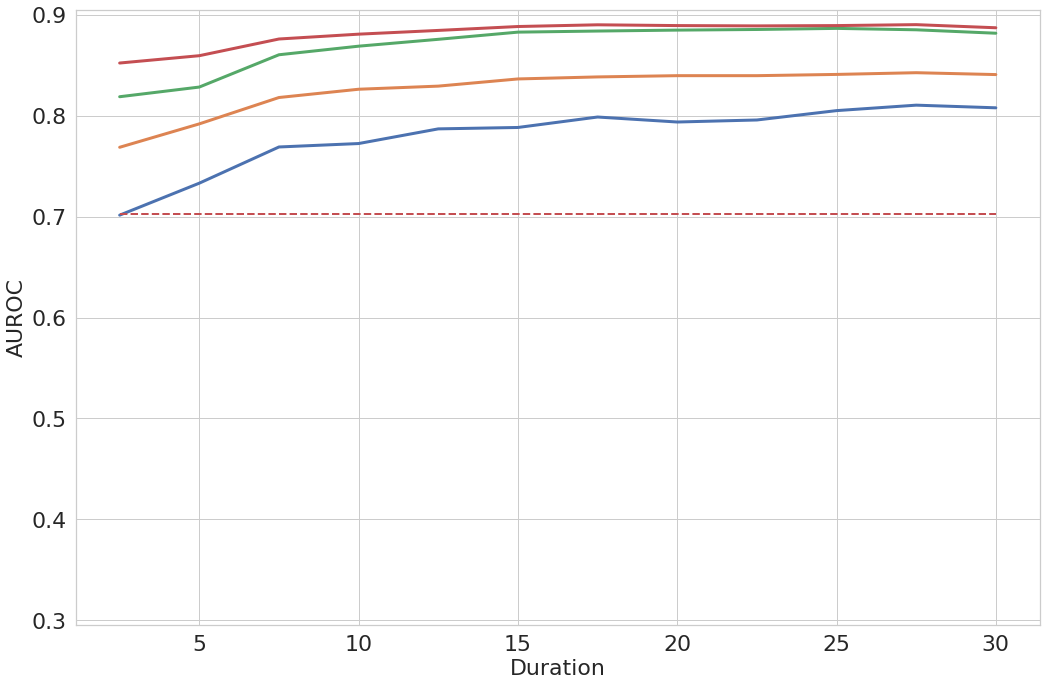

In [24]:
plot_roc_curve(max_durations, position_subsets, labels, target, baseline=0.703)

## 1. Pneumonia

In [25]:
target = [1,2]

######################### FOLD 0-1 #########################
Removing patients with multiple diagnoses
Index(['P1'], dtype='object', name='position')

######################### FOLD 1-0 #########################
Removing patients with multiple diagnoses
Index(['P1'], dtype='object', name='position')

######################### FOLD 0-2 #########################
Removing patients with multiple diagnoses
Index(['P1'], dtype='object', name='position')

######################### FOLD 2-0 #########################
Removing patients with multiple diagnoses
Index(['P1'], dtype='object', name='position')

######################### FOLD 0-3 #########################
Removing patients with multiple diagnoses
Index(['P1'], dtype='object', name='position')

######################### FOLD 3-0 #########################
Removing patients with multiple diagnoses
Index(['P1'], dtype='object', name='position')

######################### FOLD 0-4 #########################
Removing patients with multiple d

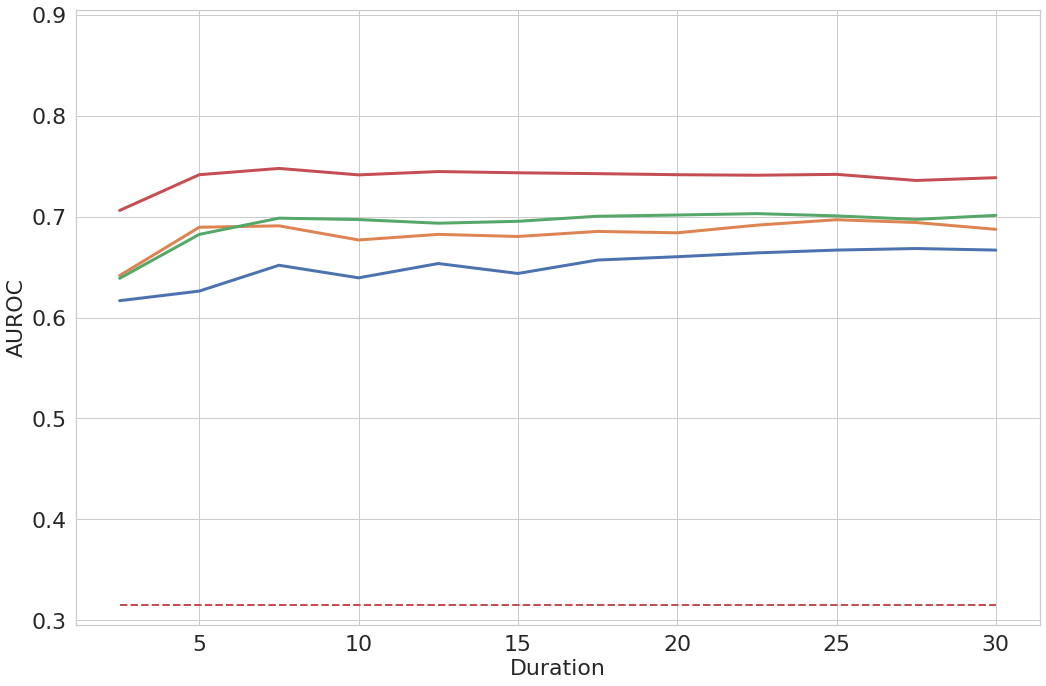

In [26]:
plot_roc_curve(max_durations, position_subsets, labels, target, baseline=0.315)

## 2. Wheezing Disorders

In [27]:
target = [3,4]

######################### FOLD 0-1 #########################
Removing patients with multiple diagnoses
Removing patients with unknown diagnosis
Index(['P1'], dtype='object', name='position')

######################### FOLD 1-0 #########################
Removing patients with multiple diagnoses
Removing patients with unknown diagnosis
Index(['P1'], dtype='object', name='position')

######################### FOLD 0-2 #########################
Removing patients with multiple diagnoses
Removing patients with unknown diagnosis
Index(['P1'], dtype='object', name='position')

######################### FOLD 2-0 #########################
Removing patients with multiple diagnoses
Removing patients with unknown diagnosis
Index(['P1'], dtype='object', name='position')

######################### FOLD 0-3 #########################
Removing patients with multiple diagnoses
Removing patients with unknown diagnosis
Index(['P1'], dtype='object', name='position')

######################### FOLD 3-0 #####

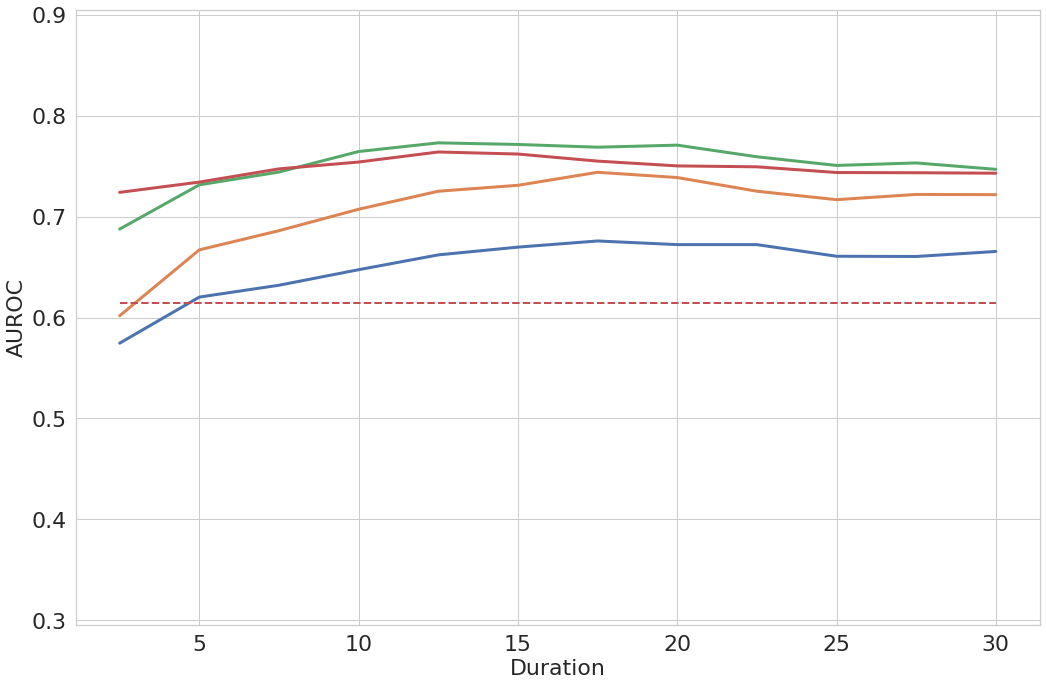

In [28]:
plot_roc_curve(max_durations, position_subsets, labels, target, baseline=0.614)

## 3. Bronchiolitis

In [29]:
target = [5]

######################### FOLD 0-1 #########################
Removing patients with multiple diagnoses
Removing patients with unknown diagnosis
Index(['P1'], dtype='object', name='position')

######################### FOLD 1-0 #########################
Removing patients with multiple diagnoses
Removing patients with unknown diagnosis
Index(['P1'], dtype='object', name='position')

######################### FOLD 0-2 #########################
Removing patients with multiple diagnoses
Removing patients with unknown diagnosis
Index(['P1'], dtype='object', name='position')

######################### FOLD 2-0 #########################
Removing patients with multiple diagnoses
Removing patients with unknown diagnosis
Index(['P1'], dtype='object', name='position')

######################### FOLD 0-3 #########################
Removing patients with multiple diagnoses
Removing patients with unknown diagnosis
Index(['P1'], dtype='object', name='position')

######################### FOLD 3-0 #####

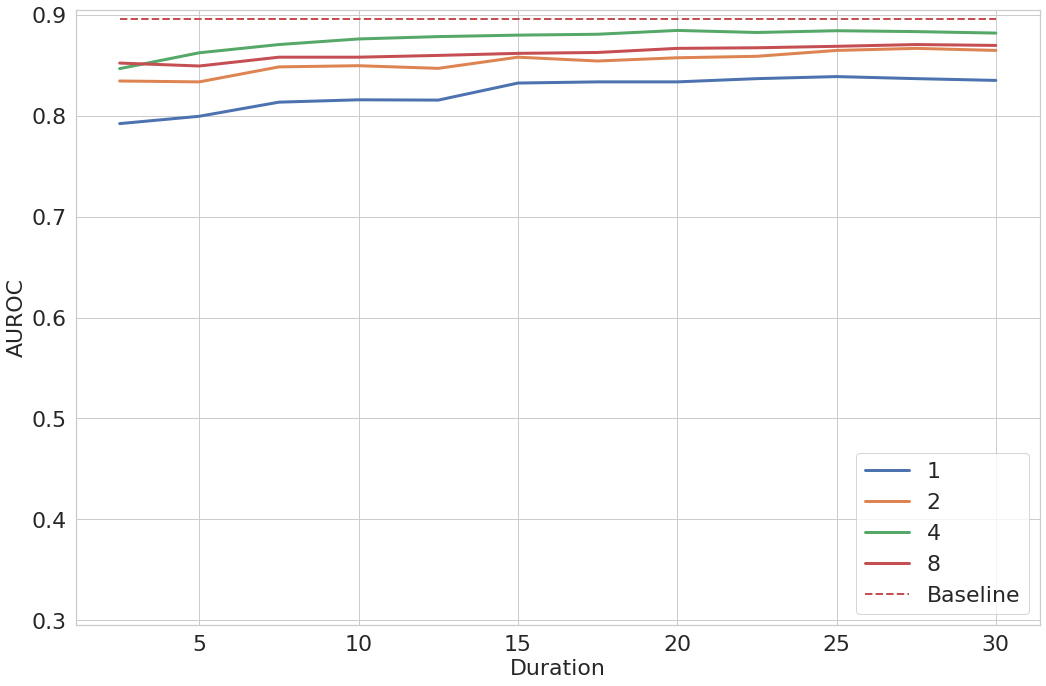

In [30]:
plot_roc_curve(max_durations, position_subsets, labels, target, baseline=0.896, show_legend=True)